<a href="https://colab.research.google.com/github/ecuadrafoy/PracticalMachineLearning/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment
Build the AlexNet architecture and train it on the CIFAR10 dataset.

You may resize some of the kernel sizes (mainly the first one) and the number of kernels because CIFAR100 is a smaller dataset than ImageNet, as well as lower-resolution (32x32 vs 224x224).

You may resize the number of kernels used per layer if it speeds up training and/or preserves accuracy. The exact AlexNet architecture and number of units will not work.

Report training, validation and test errors. Which hyperparameters did you change to improve performance?

**MAKE SURE YOU USE A GPU!** Top menu select "Runtime", then "Runtime Type". Make sure "Hardware Accelerator" has the option "GPU" selected.

Tips:
- Start with only a few of a layers and check if the network can learn.
- Add units and layers progressively.
- Kernels that are too large or too much pooling will reduce the size of layer ouputs
- Try Batch Norm and Dropout
- If you don't reproduce the exact architecture, that is fine. Explain what you changed and why!.
- Functional API!


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import datasets
import matplotlib.pyplot as plt

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


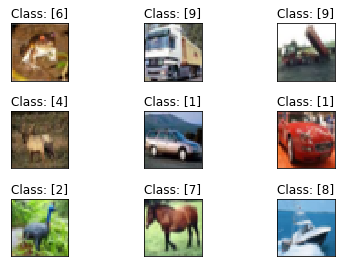

In [ ]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train_full[i], interpolation='none')
  plt.title('Class: {}'.format(y_train_full[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
X_train_full.shape

(50000, 32, 32, 3)

## Preparing the Data

* This dataset has 10 classes and are represented as unique integers. We can use one hot encoding for the class element of each sample, transforming the integer into a 10 elementary binary vector with a 1 for the index of the class



In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils 
from sklearn.model_selection import train_test_split

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)




Using TensorFlow backend.


In [ ]:
#Convert from integers to floats and scale pixels
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0
X_valid = X_valid / 255.0

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_valid = np_utils.to_categorical(y_valid)
num_classes = y_test.shape[1]
print(X_train.shape)


(45000, 32, 32, 3)


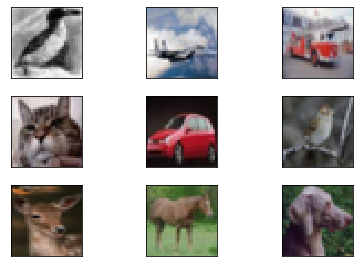

In [ ]:
fig = plt.figure()

for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.xticks([])
  plt.yticks([])

## Understanding AlexNet

As a CNN AlexNet has had a huge impact on the field of machine learning. Having an almost similar architecture as LeNet but deeper, with more filters per layer and stacked convolutional layers. 

*   It consisted of 11x11, 5x5, 3x3 convolutions
*   Max pooling
* Data augmentation
* ReLU activations, SGD with momentum
* Trained for 6 days on two Nvidia GTX 580 GPUs
* Dropout instead of regularization to deal with overfitting
* It contains 5 convolutional layers and 3 fully connected layers. Convolution layers account for 6% of the parameters but consume 95% of the computation.
![AlexNet Architecture](https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png)


In [ ]:

import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
import tensorflow.keras.backend as K



The original architecture took images that were 224x224 and used large kernels that wouldn't perform well on our 32x32. AS a result, the model had to be adjusted 

In [ ]:
#Creating AlexNet for 32x32 images
K.clear_session()


visible = Input(shape=(32,32,3))
#First Convolutional layer
conv1 = Conv2D(32,(3,3), padding = 'same', activation = 'relu')(visible)
conv1 = BatchNormalization()(conv1)

#Second Convolutional layer
conv2 = Conv2D(32,(3,3), padding = 'same', activation = 'relu')(conv1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
pool2 = BatchNormalization()(pool2)
#Third Convolutional layer
conv3 = Conv2D(64,(3,3), padding = 'same', activation = 'relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
pool3 = BatchNormalization()(pool3)

flat = Flatten()(pool3)

hidden1 = Dense(512, activation='relu')(flat)
hidden1 = Dropout(0.4)(hidden1)
hidden1 = BatchNormalization()(hidden1)

hidden2 = Dense(512, activation='relu')(hidden1)
hidden2 = Dropout(0.4)(hidden2)
hidden2 = BatchNormalization()(hidden2)

hidden3 = Dense(1000, activation='relu')(hidden2)
hidden3 = Dropout(0.4)(hidden3)
hidden3 = BatchNormalization()(hidden3)

output = Dense(num_classes, activation='softmax')(hidden3)

AlexNet = Model(inputs=visible, outputs=output)

In [ ]:
AlexNet.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128 

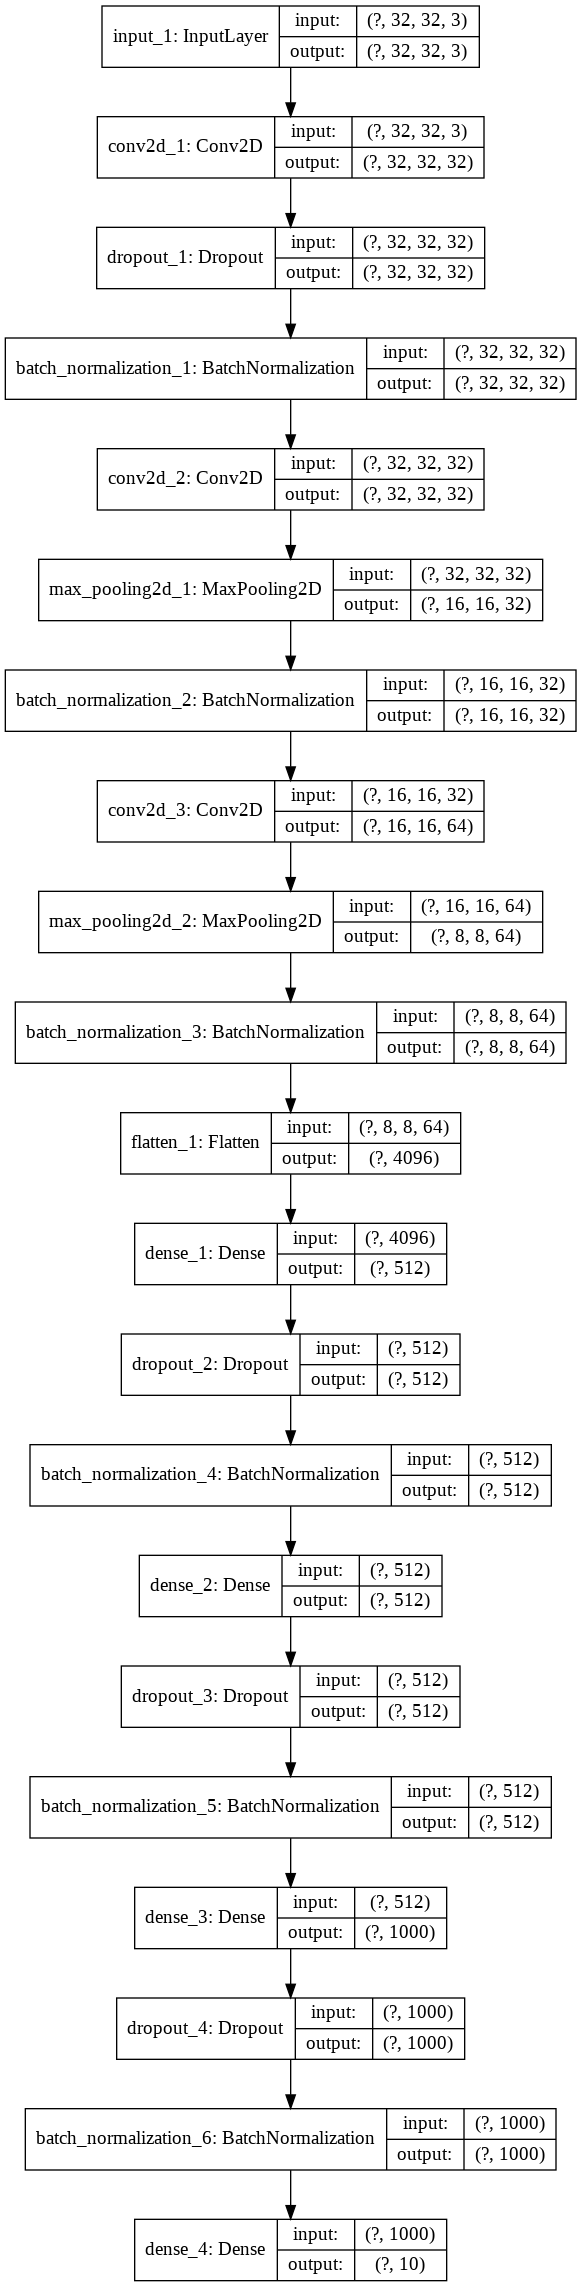

In [ ]:
tf.keras.utils.plot_model(
    AlexNet, 
    to_file='pic.png', 
    show_shapes=True, 
    show_layer_names=True
)


In [ ]:
AlexNet.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:
h = AlexNet.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=32)

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 18s 399us/step - loss: 1.6019 - accuracy: 0.4493 - val_loss: 1.0618 - val_accuracy: 0.6246
Epoch 2/30
45000/45000 [==============================] - 18s 389us/step - loss: 1.1029 - accuracy: 0.6127 - val_loss: 0.9412 - val_accuracy: 0.6624
Epoch 3/30
45000/45000 [==============================] - 17s 380us/step - loss: 0.9630 - accuracy: 0.6649 - val_loss: 0.8452 - val_accuracy: 0.7092
Epoch 4/30
45000/45000 [==============================] - 17s 381us/step - loss: 0.8509 - accuracy: 0.7048 - val_loss: 0.7553 - val_accuracy: 0.7308
Epoch 5/30
45000/45000 [==============================] - 17s 376us/step - loss: 0.7876 - accuracy: 0.7245 - val_loss: 0.7933 - val_accuracy: 0.7298
Epoch 6/30
45000/45000 [==============================] - 17s 378us/step - loss: 0.7151 - accuracy: 0.7541 - val_loss: 0.8254 - val_accuracy: 0.7188
Epoch 7/30
45000/45000 [==============================] -

In [ ]:
scores = AlexNet.evaluate(X_valid, y_valid, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


5000/5000 [==============================] - 1s 127us/step
Accuracy: 75.04%


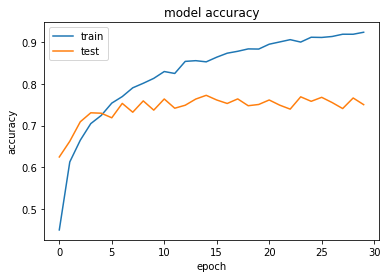

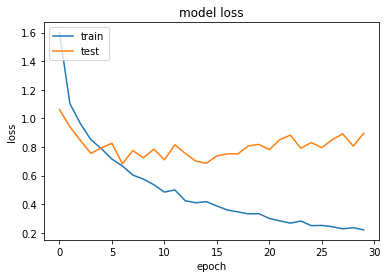

In [ ]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Adjusting some hyperparameters
*   Our model is currently suffering from overfitting as seen by the increase in accuracy on the Train set compared to the Testing set
* We can attempt to modify some hyperparameters in the Compile portion of the `AlexNet` model like using `RMSprop()` optimizer and a learning rate of 0.001

In [ ]:
AlexNet.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), metrics = ['accuracy'])

In [ ]:
h2 = AlexNet.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=30, batch_size=32)

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 28s 613us/step - loss: 0.2380 - accuracy: 0.9255 - val_loss: 0.8698 - val_accuracy: 0.7450
Epoch 2/30
45000/45000 [==============================] - 27s 604us/step - loss: 0.2510 - accuracy: 0.9197 - val_loss: 1.2513 - val_accuracy: 0.7206
Epoch 3/30
45000/45000 [==============================] - 27s 607us/step - loss: 0.2446 - accuracy: 0.9204 - val_loss: 1.0531 - val_accuracy: 0.7422
Epoch 4/30
45000/45000 [==============================] - 27s 610us/step - loss: 0.2397 - accuracy: 0.9222 - val_loss: 0.8941 - val_accuracy: 0.7694
Epoch 5/30
45000/45000 [==============================] - 28s 614us/step - loss: 0.2275 - accuracy: 0.9250 - val_loss: 0.8803 - val_accuracy: 0.7478
Epoch 6/30
45000/45000 [==============================] - 28s 614us/step - loss: 0.2296 - accuracy: 0.9247 - val_loss: 0.8859 - val_accuracy: 0.7770
Epoch 7/30
45000/45000 [==============================] -

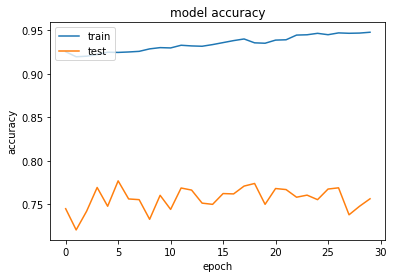

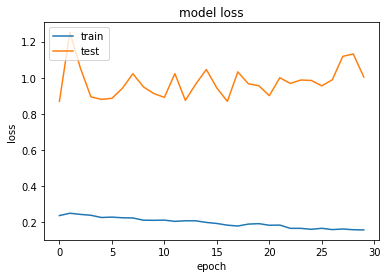

In [ ]:
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Data Augmentation 

*   It seems that there hasn't been any improvement to our model, the Training set performs well but it's staying the same for the test set. 
* I will attempt to augment the data
* The final accuracy score reveals a jump from 75% previously to almost 81% using only data augmentation.
* We can see that the model has a difficult time differentiating between a cat and a dog



In [ ]:
K.clear_session()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import h5py

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

steps = int(X_train.shape[0] / 64)

AlexNet.compile(loss='categorical_crossentropy', optimizer = RMSprop(lr=0.001), metrics = ['accuracy'])

h3 = AlexNet.fit(datagen.flow(X_train, y_train, batch_size = 64), steps_per_epoch=steps, validation_data=(X_valid, y_valid), epochs=100, verbose=2)


Epoch 1/100
 - 35s - loss: 1.6763 - accuracy: 0.4327 - val_loss: 1.0162 - val_accuracy: 0.6414
Epoch 2/100
 - 34s - loss: 1.1614 - accuracy: 0.5918 - val_loss: 1.0944 - val_accuracy: 0.6144
Epoch 3/100
 - 33s - loss: 1.0078 - accuracy: 0.6515 - val_loss: 0.9420 - val_accuracy: 0.6768
Epoch 4/100
 - 33s - loss: 0.9249 - accuracy: 0.6820 - val_loss: 0.7333 - val_accuracy: 0.7460
Epoch 5/100
 - 34s - loss: 0.8715 - accuracy: 0.7040 - val_loss: 0.7122 - val_accuracy: 0.7542
Epoch 6/100
 - 33s - loss: 0.8199 - accuracy: 0.7199 - val_loss: 0.7198 - val_accuracy: 0.7580
Epoch 7/100
 - 33s - loss: 0.7929 - accuracy: 0.7294 - val_loss: 0.7625 - val_accuracy: 0.7420
Epoch 8/100
 - 33s - loss: 0.7610 - accuracy: 0.7408 - val_loss: 0.6563 - val_accuracy: 0.7838
Epoch 9/100
 - 33s - loss: 0.7239 - accuracy: 0.7542 - val_loss: 0.7168 - val_accuracy: 0.7652
Epoch 10/100
 - 33s - loss: 0.7099 - accuracy: 0.7599 - val_loss: 0.6193 - val_accuracy: 0.7968
Epoch 11/100
 - 32s - loss: 0.6981 - accuracy: 0.

In [ ]:
AlexNet.save('Alex.h5')

5000/5000 [==============================] - 1s 245us/step
Accuracy: 82.42%


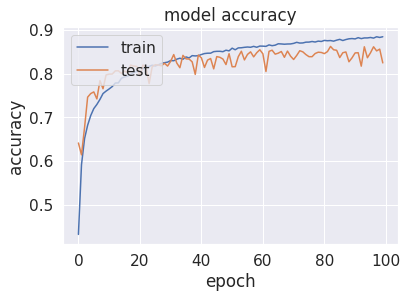

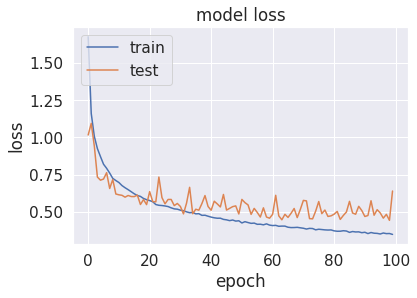

In [ ]:
scores = AlexNet.evaluate(X_valid, y_valid, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))


plt.plot(h3.history['accuracy'])
plt.plot(h3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h3.history['loss'])
plt.plot(h3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = AlexNet.predict(X_test, verbose = 2)
y_pred = np.argmax(Y_pred, axis = 1)

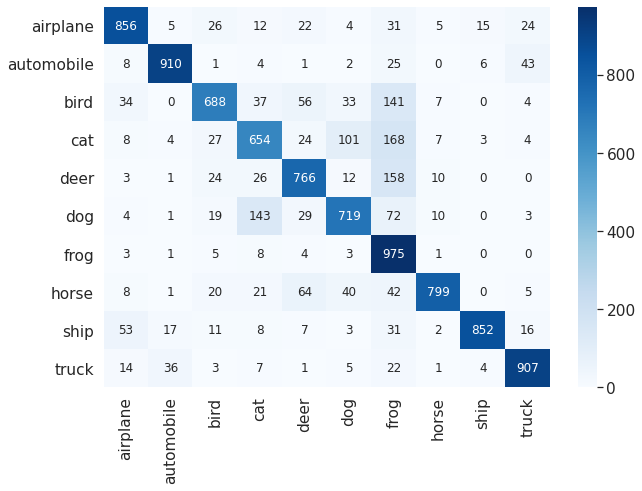

In [ ]:
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)

import seaborn as sn
import pandas  as pd

x_class=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_class = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12}, cmap=plt.cm.Blues, xticklabels=x_class, yticklabels=y_class, fmt = 'g')# font size
plt.show();


## Could the Model see my Cat?

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model



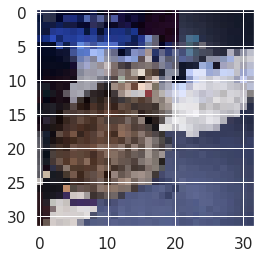

In [ ]:
imgshow = load_img('cat.jpg',target_size=(32,32))
plt.imshow(imgshow)



In [ ]:
# load and prepare the image
def load_image(filename):
	img = load_img(filename, target_size=(32, 32))
	img = img_to_array(img)
	img = img.reshape(1, 32, 32, 3)
	img = img.astype('float32')
	img = img / 255.0
	return img


Detecting my Cat

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

img = load_image('cat.jpg')
model = load_model('Alex.h5')
result = AlexNet.predict(img)[0]


np.set_printoptions(formatter={'float': '{: 0.3f}'.format}, suppress=False)

print(result)

[ 0.000  0.000  0.010  0.643  0.021  0.053  0.272  0.002  0.000  0.000]


Looking at a random cat

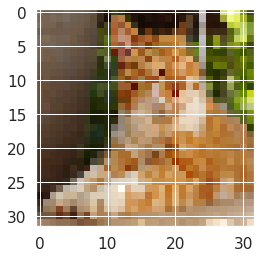

In [ ]:
imgshow = load_img('randomcat.jpg',target_size=(32,32))
plt.imshow(imgshow)

In [ ]:
img = load_image('randomcat.jpg')
model = load_model('Alex.h5')
result = AlexNet.predict(img)[0]

np.set_printoptions(formatter={'float': '{: 0.3f}'.format}, suppress=False)
print(result)

[ 0.003  0.003  0.012  0.777  0.008  0.030  0.144  0.012  0.004  0.007]


Looking at a Friend's Dog

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[ 0.020  0.000  0.030  0.128  0.008  0.692  0.023  0.087  0.000  0.013]


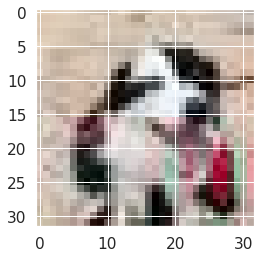

In [ ]:
imgshow = load_img('riderthedog.jpg',target_size=(32,32))
plt.imshow(imgshow)

img = load_image('riderthedog.jpg')
model = load_model('Alex.h5')
result = AlexNet.predict(img)[0]

np.set_printoptions(formatter={'float': '{: 0.3f}'.format}, suppress=False)
print(x_class)
print(result)
